In [1]:
import pandas as pd
import numpy as np
import os
import json
import plotly.express as px


README 

1. Coletar dados

# @julio Blablabla sobre a coleta de dados.
# @julio Mostrar falhas usando ntscrape e snscrape e explicar coleta via Apify
# @rodrigoFalar sobre coleta de dados de divulgações de balanço e DATACOMs
    -> Citar script demonstrativos_scrapper.py

2. Realizar pré processamento dos dados

# @julio Tweets de ações

- Definição de tipos do dataframe
# Verificar os tipos (converter datetimes mudar index para datetime)

- Busca por dados ausentes e tratamento
# - Tweets de ações
    - Não vai ter. (mas lembrar de mostrar isso)
    - Comentar como podemos tratar dias que NÃO possuem Tweets

- Normalização e discretização
# - Tweets de ações
    - Discutir sobre normalização de features numéricas que possamos usar como: num_likes, num_retweets, features extraidas de modelos

- Limpeza de dados 
    # - Tweets de ações
        - Tweets que NÃO acrescentam informações relevantes.

3. Apresentar estatísticas descritivas dos dados com visualizações

- Tweets de ações
    - Box plot do número de palavras dos tweets
    - Visualização da redução de dimensionalidade dos tweets
    - Boxplots dos escores de NLI (pode até mesmo ser por tempo/média móvel)
    - @rodrigo Plots de distribuição de ngramas


4. Realizar teste de hipóteses para comparação de valores de categorias
    - Teste de hipótese que o preço da ação cai após o Datacom
    - @rodrigo Teste de hipotése ZIPFS nos tweets

=======================================================

5. Extra: Juntar os dados em um único dataframe
[Perguntar pra Luciano]

colunas:
features do candle, texto dos principais tweets do dia,
[17:53, 11/06/2024] Júlio Cesar: E sim, so pra lembrar que o plano final foi separar dois READMEs (um para texto e outro para CANDLE das acoes)

E depois a gente completa o README final com uma síntese

Notebook contendo pré-processamentos e análises respectivos apenas à dados de tweets. 

# 1. Contexto e Motivação: Uso de tweets como insumo de informação

No contexto de predição de preço de ações, as análises técnicas e fundamentalista são abordagens distintas na predição do preço de ações. A primeira foca em padrões históricos de preço e volume, utilizando gráficos e indicadores para prever movimentos futuros com base no comportamento passado do mercado. Já a análise fundamentalista avalia o valor intrínseco de uma ação, considerando fatores econômicos, financeiros e qualitativos, como balanços patrimoniais, lucros, gestão da empresa e condições macroeconômicas.

Pesquisas indicam que dados textuais respectivos à impressão do público sobre ações são relevantes para o desempenho de modelos de predição de preço de ações \[1,2\]. Essas duas abordagens citadas utilizaram tweets como insumos de informação para apoiar a predição dos modelos. O uso de tweets permite captar o sentimento do mercado e as percepções dos investidores em tempo real, enriquecendo a análise com informações atualizadas e potencialmente influentes sobre eventos e mudanças no mercado que podem afetar os preços das ações de forma rápida e significativa. Nesse contexto, incluímos **tweets** como insumo de informação para predição de preço de ações!

<br>

\[1] *Xu et al, "Stock Movement Prediction from Tweets and Historical Prices", Proceedings of the 56th Annual Meeting of the Association for Computational Linguistics, 2018* 

\[2] *G. Vargas et al, "B3 Stock Price Prediction Using LSTM Neural Networks and Sentiment Analysis," in IEEE Latin America Transactions, vol. 20, 2022* 

# 2. Coleta de dados

Sem acesso à API do Twitter, devido à mesma ser paga, e após tentativas falhas de coletar tweets de ações utilizando projetos de scrappers como `snscrape` e `ntscrape`, utilizamos a plataforma `Apify` para coleta de tweets. Essa aplicação nos permitia filtrar por tweets contivessem determinadas strings em um intervalo determinado de tempo, porém retornando no máximo 100 tweets, independente do intervalo de coleta, durante nossos testes.


Assim como o dataset de referência na literatura publicado em [1], o StockNet Dataset, nós coletamos dados no período de 2 anos das ações escolhidas. Como ações do nosso projeto, escolhemos `PETR4` e `VALE3` por serem de nosso interesse pessoal e serem empresas bastante conhecidas que deveriam retornar quantidades razoáveis de tweets.  


Considerando a limitação do Apify de coletar 100 tweets independente do intervalo de tempo fornecido, fizemos coletas em 24 intervalos de 1 em 1 mês para PETR4 e VALE3 de forma separada. Consideramos a data de início de coleta de 01/06/2022 e a data final de 01/06/2024, utilizando as strings "PETR4" e "VALE3" para buscar pelas ações desejadas. Todas as coletas mensais retornaram o limite de 100 tweets, portanto, coletamos 2400 tweets de PETR4 e 2400 tweets de VALE3, totalizando 4800 tweets no formato JSON. 

In [2]:
def extract_df_from_json_tweets_data(path_tweets,
                                    relevant_fields = ['author','text','createdAt'],
                                    relevant_author_fields = ['userName','description']):
    dict_list = []

    # For each JSON
    for filename in os.listdir(path_tweets):
        if filename[-4:] != 'json':
            continue

        with open(os.path.join(path_tweets, filename), 'rt', encoding= 'utf8') as f:
            curr_json_list = json.load(f)

        # For each single tweet in a JSON
        for curr_json in curr_json_list:
            # Extract only relevant fields from tweet
            relevant_json = {k:v for k,v in curr_json.items() if k in relevant_fields}
            
            relevant_json_author = {f'author_{k}':v for k,v in relevant_json['author'].items() if k in relevant_author_fields}

            # Delete semi-structured author field in `relevant_json`
            del relevant_json['author']

            # Merging the two dataframes and specifying original file
            new_dict = {**relevant_json, **relevant_json_author}
            new_dict['src_file'] = filename
            dict_list.append(new_dict)

    df = pd.DataFrame(dict_list)
    return df

In [3]:
RELEVANT_FIELDS = ['type','id','text','retweetCount','replyCount','likeCount','createdAt','bookmarkCount','isReply','author']
RELEVANT_AUTHOR_FIELDS = ['type','userName','name','isVerified','description','followers','following','createdAt','favouritesCount']
PATH_PETR4 = '../data/PETR4'
PATH_VALE3 = '../data/VALE3'


df_petr4 = extract_df_from_json_tweets_data(PATH_PETR4, relevant_fields=RELEVANT_FIELDS, relevant_author_fields=RELEVANT_AUTHOR_FIELDS)
df_vale3 = extract_df_from_json_tweets_data(PATH_VALE3, relevant_fields=RELEVANT_FIELDS, relevant_author_fields=RELEVANT_AUTHOR_FIELDS)

df_petr4['stock'] = 'PETR4'
df_vale3['stock'] = 'VALE3'

df_stocks = pd.concat([df_petr4, df_vale3], ignore_index=True)
df_stocks

,type,id,text,retweetCount,replyCount,likeCount,createdAt,bookmarkCount,isReply,author_type,author_userName,author_name,author_isVerified,author_description,author_followers,author_following,author_createdAt,author_favouritesCount,src_file,stock
0,tweet,1739773497541324985,"Não só a máxima do ano, mas #PETR4 teve a seu ...",2,0,11,Tue Dec 26 22:21:39 +0000 2023,0,False,user,JJJJames16,JJJJames,False,,1501,291,Fri Jul 24 03:12:35 +0000 2020,8283,dataset_petr4-top-tweets-from-1-month_2023-12....,PETR4
1,tweet,1736796654705991820,Como o gestor do fundo “IBIUNA LONG BIASED FIM...,1,0,6,Mon Dec 18 17:12:45 +0000 2023,0,False,user,carteirafundos,Carteira Fundos,False,Acompanhe as posições dos fundos de investimen...,3711,233,Wed May 03 23:50:09 +0000 2023,853,dataset_petr4-top-tweets-from-1-month_2023-12....,PETR4
2,tweet,1740106748630008303,Anual de #PETR4 https://t.co/Yxa38SOuTM,1,2,14,Wed Dec 27 20:25:53 +0000 2023,0,False,user,marcioportes,Marcio Portes,True,Compro e vendo Velas. #fibonaccing,12358,344,Thu Jun 11 03:41:02 +0000 2009,28704,dataset_petr4-top-tweets-from-1-month_2023-12....,PETR4
3,tweet,1741503350040924192,Patrocinado por futuro breve short em Ibovespa...,4,13,140,Sun Dec 31 16:55:28 +0000 2023,3,False,user,ManfroiRenato,cansera ok,True,youtube https://t.co/MyUiB8MUbV?amp=1\n\n\n\...,28791,2158,Sat Jun 29 15:09:30 +0000 2019,25765,dataset_petr4-top-tweets-from-1-month_2023-12....,PETR4
4,tweet,1741089114387038700,#PETR4 *gráfico não ajustado! Há 3 anos que ro...,2,2,34,Sat Dec 30 13:29:27 +0000 2023,0,False,user,marcioportes,Marcio Portes,True,Compro e vendo Velas. #fibonaccing,12358,344,Thu Jun 11 03:41:02 +0000 2009,28704,dataset_petr4-top-tweets-from-1-month_2023-12....,PETR4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,tweet,1553101436241715200,Vale (VALE3) após balanço ‘decepcionante’ do 2...,0,0,1,Fri Jul 29 19:33:32 +0000 2022,0,False,user,leiamoneytimes,Money Times,False,🗞️💰💡 Notícias que enriquecem seu dia! \n\nNão ...,144864,26,Fri Jun 26 17:45:06 +0000 2009,1778,dataset_petr4-top-tweets-from-1-month_2024-06-...,VALE3
4796,tweet,1553088819364352002,⛏ Há mais de um ano fazendo recompras de ações...,0,0,5,Fri Jul 29 18:43:24 +0000 2022,1,False,user,tcinvestimentos,TC,True,"Às vezes, tudo o que você precisa é de um impu...",95931,9,Mon Aug 22 16:42:11 +0000 2016,1883,dataset_petr4-top-tweets-from-1-month_2024-06-...,VALE3
4797,tweet,1553082832347602947,Vale (VALE3) avalia que licenciamentos estão m...,0,0,1,Fri Jul 29 18:19:36 +0000 2022,0,False,user,leiamoneytimes,Money Times,False,🗞️💰💡 Notícias que enriquecem seu dia! \n\nNão ...,144864,26,Fri Jun 26 17:45:06 +0000 2009,1778,dataset_petr4-top-tweets-from-1-month_2024-06-...,VALE3
4798,tweet,1553145484600115200,Toro está confiante com Vale (VALE3) e indica ...,0,0,3,Fri Jul 29 22:28:34 +0000 2022,0,False,user,leiamoneytimes,Money Times,False,🗞️💰💡 Notícias que enriquecem seu dia! \n\nNão ...,144864,26,Fri Jun 26 17:45:06 +0000 2009,1778,dataset_petr4-top-tweets-from-1-month_2024-06-...,VALE3


# 3. Extração de features dos dados textuais

Modelos não podem receber diretamente dados textuais como entrada. Apesar disso, podemos extrair features numéricas que extraiam informações numéricas que possam ser utilizadas por modelos. Para isso, inicialmente pensamos em duas abordagens:

**A. Extração de embeddings utilizando modelos baseados no BERT**

## 3.1 Extração de embeddings utilizando modelos baseados no BERT

Utilizamos o modelo XLM RoBERTa Large, que é um modelo de múltiplas línguas com desempenho interessante também na língua portuguesa e o modelo BERTimbau base, que é um modelo BERT treinado com dados em português. Os códigos se encontram no notebook `BERT_feature_extraction.ipynb` e também podem ser vistos pelo Colab (https://colab.research.google.com/drive/11WK5Boyoxgl5mL8TB3RSs1oBliR44aI7?usp=sharing)

Os embeddings extraídos utilizando o embedding token \[CLS] para cada um desses modelos, para cada ação se encontram no Google Drive. Os mesmos não serão carregados nesse notebook para evitarmos ter um dataframe muito pesado e por não ser necessário realizar mais nenhum pré-processamento em cima deles. 

## 3.2 Extração da relação dos textos com palavras-chave

Podemos usar modelos treinados para a tarefa de Recognizing Textual Entailment (RTE) \[também conhecida como Natural Language Inference (NLI)], os quais tem o objetivo de determinar a relação de duas sentenças.

Pode ser interessante para nós extrairmos a relação dos tweets com ideias como: "valorização", "neutro", "desvalorização", "lucro", "prejuízo", "positivo", "negativo", "governo", "bom negócio", "mau negócio"

Para isso, consideramos o modelo `MoritzLaurer/mDeBERTa-v3-base-mnli-xnli`, que passou por um finetuning para 100 linguagens, inclusive português, e pode ser usado para classificação textual zero-shot. Os códigos se encontram no notebook `NLI.ipynb` e também podem ser vistos pelo Colab (https://colab.research.google.com/drive/1Q-UXLS9CigqYrzp0fpA6xF9L8YkDGQRy#scrollTo=aCUaKIabBGDk).

Após rodar esses códigos, criamos um dataframe com as colunas ["valorização", "bom negócio", "lucro", "neutro", "desvalorização", "mau negócio", "prejuízo", "governo"] contendo o grau de relação de cada tweet com essas categorias. Esse grau de relação varia de 0 a 1 para todas as colunas.

In [12]:
df_tweets_keywords_relations = pd.read_csv('../data/addiitonal_features/tweets_keywords_relations.csv')

In [13]:
df_stocks = pd.merge(df_stocks, df_tweets_keywords_relations, on='text', how='inner')

In [14]:
df_stocks.head(2)

,type,id,text,retweetCount,replyCount,likeCount,createdAt,bookmarkCount,isReply,author_type,...,src_file,stock,valorização,bom negócio,lucro,neutro,desvalorização,mau negócio,prejuízo,governo
0,tweet,1739773497541324985,"Não só a máxima do ano, mas #PETR4 teve a seu ...",2,0,11,Tue Dec 26 22:21:39 +0000 2023,0,False,user,...,dataset_petr4-top-tweets-from-1-month_2023-12....,PETR4,0.500764,0.337324,0.168548,0.004507,0.019380,0.000749,0.013893,0.405026
1,tweet,1736796654705991820,Como o gestor do fundo “IBIUNA LONG BIASED FIM...,1,0,6,Mon Dec 18 17:12:45 +0000 2023,0,False,user,...,dataset_petr4-top-tweets-from-1-month_2023-12....,PETR4,0.997692,0.836978,0.384830,0.000452,0.002002,0.000808,0.143259,0.950638


# 4. Pré-processamento dos dados

## 4.1 Definição de tipos do dataframe

In [15]:
df_stocks.dtypes

type                       object
id                         object
text                       object
retweetCount                int64
replyCount                  int64
likeCount                   int64
createdAt                  object
bookmarkCount               int64
isReply                      bool
author_type                object
author_userName            object
author_name                object
author_isVerified            bool
author_description         object
author_followers            int64
author_following            int64
author_createdAt           object
author_favouritesCount      int64
src_file                   object
stock                      object
valorização               float64
bom negócio               float64
lucro                     float64
neutro                    float64
desvalorização            float64
mau negócio               float64
prejuízo                  float64
governo                   float64
dtype: object

As colunas `createdAt` e `author_createdAt`, em vez de terem dtype de `object` deveriam ser `datetime`. 

Além disso, é conviente realizarmos uma codificação de colunas com valores booleanos para valores inteiros, codificando False como 0 e True como 1. Isso vai possibilitar que as mesmas possam ser usadas por modelos

Vamos fazer essa correção

In [16]:
df_stocks['createdAt'] = pd.to_datetime(df_stocks['createdAt'], format='%a %b %d %H:%M:%S %z %Y')
df_stocks['author_createdAt'] = pd.to_datetime(df_stocks['author_createdAt'], format='%a %b %d %H:%M:%S %z %Y')
df_stocks['isReply'] = df_stocks['isReply'].map({False:0, True:1})
df_stocks['author_isVerified'] = df_stocks['author_isVerified'].map({False:0, True:1})


df_stocks.dtypes

type                                   object
id                                     object
text                                   object
retweetCount                            int64
replyCount                              int64
likeCount                               int64
createdAt                 datetime64[ns, UTC]
bookmarkCount                           int64
isReply                                 int64
author_type                            object
author_userName                        object
author_name                            object
author_isVerified                       int64
author_description                     object
author_followers                        int64
author_following                        int64
author_createdAt          datetime64[ns, UTC]
author_favouritesCount                  int64
src_file                               object
stock                                  object
valorização                           float64
bom negócio                       

## 4.2 Configurando o index do dataframe como a data de criação do tweet

Essa nova configuração do index vai nos ajudar a realizar análises que investigam a variações de características do dataset ao longo do tempo

In [17]:
df_stocks = df_stocks.set_index('createdAt')
df_stocks.head(1)

,type,id,text,retweetCount,replyCount,likeCount,bookmarkCount,isReply,author_type,author_userName,...,src_file,stock,valorização,bom negócio,lucro,neutro,desvalorização,mau negócio,prejuízo,governo
createdAt,,,,,,,,,,,,,,,,,,,,,
2023-12-26 22:21:39+00:00,tweet,1739773497541324985,"Não só a máxima do ano, mas #PETR4 teve a seu ...",2,0,11,0,0,user,JJJJames16,...,dataset_petr4-top-tweets-from-1-month_2023-12....,PETR4,0.500764,0.337324,0.168548,0.004507,0.01938,0.000749,0.013893,0.405026


## 4.3 Busca por dados ausentes e tratamento

In [ ]:
df_stocks.isna().sum()

Visto que NÃO temos nenhum dado ausente nos dados coletados, não é necessário adotar nenhum tratamento no momento.

Porém, caso seja desejado tratar dos dados textuais de tweets e de dados numéricos relacionados ao histórico do preço de ações, teremos que tratar casos em que alguns dias NÃO terão nenhum tweet relacionado às ações em nosso dataset

## 4.4 Normalização e discretização

No caso do dataset dos tweets, temos features numéricas que fazem sentido serem normalizadas. Podemos fazer isso para `['retweetCount', 'replyCount', 'likeCount', 'bookmarkCount', 'author_followers', 'author_following', 'author_favouritesCount']`

Uma abordagem válida para normalizar essas features é a de StandardScaler, até porque não existe um limitante superior dessas features para utilizarmos o MinMaxScaler.

**Porém, seria uma metodologia errada normalizarmos todos os dados do dataset juntos e depois, na fase de modelagem, dividirmos os conjuntos em treino, validação e teste. Isso seria errado pois ocorreriam vazamentos de estatísticas do conjunto de teste para o treino e validação**. Portanto, primeiramente vamos dividir os conjuntos em treino/validação e teste.

### 4.4.1 Separando os dados entre treino/validação e teste

Vamos considerar os últimos 4 meses de coleta de dados como o conjunto de teste. Portanto, a partir do dia 01 de fevereiro de 2024, vamos considerar como o conjunto de teste

In [36]:
cutoff_date = pd.to_datetime('2024-02-01')

df_stocks_train_val = df_stocks[:'2024-02-01']
df_stocks_test = df_stocks['2024-02-01':]

/tmp/ipykernel_73661/1439567318.py:4: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_stocks_test = df_stocks['2024-02-01':]


In [37]:
from sklearn.preprocessing import StandardScaler

In [40]:
numeric_columns = df_stocks.dtypes[df_stocks.dtypes.isin(['int64', 'float64'])].index

std_scal = StandardScaler()
std_scal.fit(df_stocks_train_val[numeric_columns])
stocks_train_val_normalized_cols = std_scal.transform(df_stocks_train_val[numeric_columns])
stocks_test_normalized_cols = std_scal.transform(df_stocks_test[numeric_columns])

df_stocks_train_val_normalized_cols = pd.DataFrame(stocks_train_val_normalized_cols, columns=[f'norm_{col}' for col in numeric_columns])
df_stocks_test_normalized_cols = pd.DataFrame(stocks_test_normalized_cols, columns=[f'norm_{col}' for col in numeric_columns])

In [45]:
df_stocks_train_val_normalized_cols.head(2)

,norm_retweetCount,norm_replyCount,norm_likeCount,norm_bookmarkCount,norm_isReply,norm_author_isVerified,norm_author_followers,norm_author_following,norm_author_favouritesCount,norm_valorização,norm_bom negócio,norm_lucro,norm_neutro,norm_desvalorização,norm_mau negócio,norm_prejuízo,norm_governo
0,-0.031123,-0.130682,-0.086368,-0.103869,-0.02166,-0.86112,-0.373289,-0.161510,-0.308150,-0.440633,-0.604833,-0.695998,-0.159817,-1.014583,-0.611153,-0.865000,0.129372
1,-0.056216,-0.130682,-0.102756,-0.103869,-0.02166,-0.86112,-0.362739,-0.179462,-0.507667,0.962595,0.981456,-0.060000,-0.194811,-1.057017,-0.610961,-0.518185,1.765658


### 4.5 Limpeza dos dados

No nosso caso, faria sentido remover tweets irrelevantes do dataset. Porém, como achar tweets irrelevantes? Uma forma é depois de realizar uma análise exploratória. Vamos seguir com uma análise exploratória inicialmente:

# 5. Apresentar estatísticas descritivas dos dados com visualizações

As estatísticas e visualizações estão no notebook `BERT_feature_extraction.ipynb`. Por exemplo, a análise de eventos textuais através do plot com redução de dimensionalidade: 

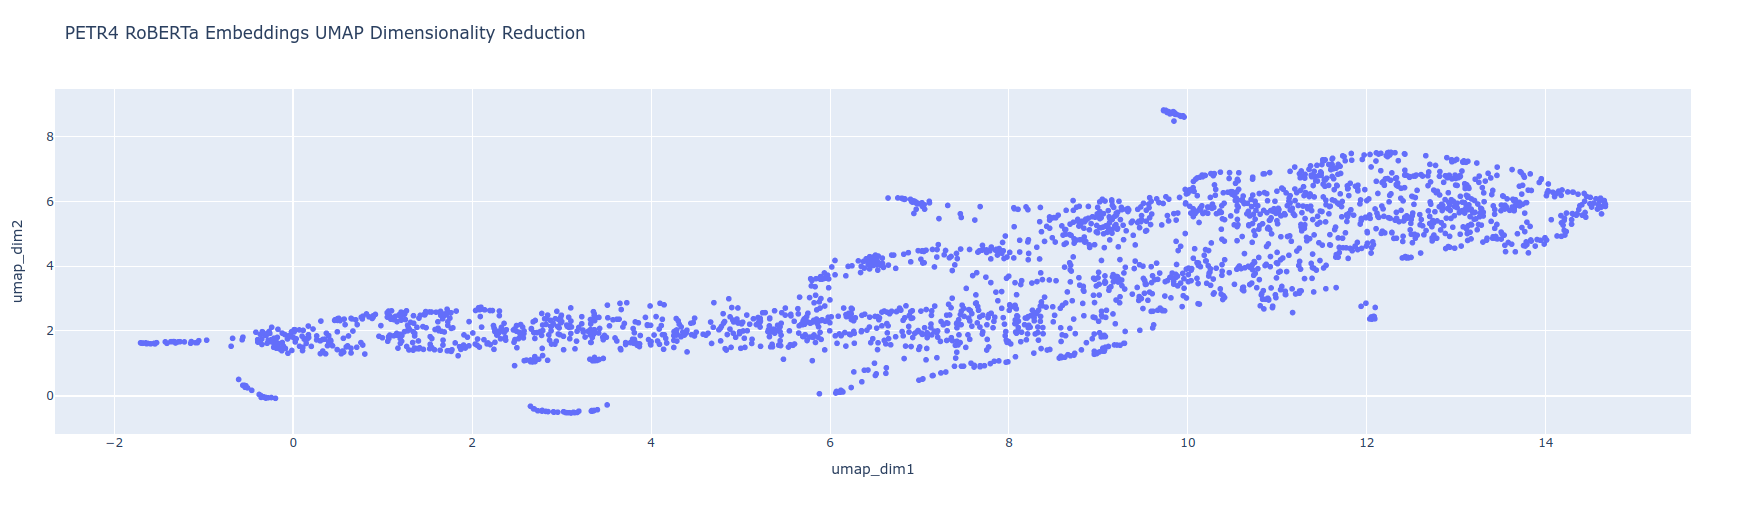